# Optimization project: clustering

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
import functools
import operator
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance

__Given that we don't have the proper datafiles to run the code, we will use synthetic ones to still do the work, and
as soon as we have the real files we will just substitute them.__

In [44]:
#Simulate dataframe
def simulate_data_2(N):
    X1 = np.random.uniform(low=0, high=25, size=(N))
    X2 = np.random.uniform(low=0, high=25, size=(N))
    return X1, X2

In [ ]:
X1, X2 = simulate_data_2(200)

In [2]:
def simulate_data_5(N):
    X1 = np.random.uniform(low=0, high=25, size=(N))
    X2 = np.random.uniform(low=0, high=25, size=(N))
    X3 = np.random.uniform(low=0, high=25, size=(N))
    X4 = np.random.uniform(low=0, high=25, size=(N))
    X5 = np.random.uniform(low=0, high=25, size=(N))
    return X1, X2, X3, X4, X5 

In [6]:
X1, X2, X3, X4, X5 = simulate_data_5(200)

# Minimum Spanning Tree Clustering


## Computing all the distances

In [7]:
from scipy.spatial import distance
def compute_dist(df):
    result = []
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            d = distance.euclidean(df.iloc[i].to_list(),df.iloc[j].to_list())
            result.append([i, j, d])

    ordered_result = sorted(result, key=lambda t: t[::-1])
    return ordered_result

In [8]:
df = pd.DataFrame({'X1': X1, 'X2': X2,'X3': X3, 'X4': X4, 'X5': X5}, columns=['X1', 'X2','X3', 'X4', 'X5'])

In [9]:
ordered_result = compute_dist(df)

## MST

To find the minimum spanning tree it makes sense to differentiate the following cases:

    case 1: None of them are in a cluster:
    case 2: Only one of them is already in a cluster:
    case 3: Both of them are already in a cluster:
        --> 3a: Both of them are in the same cluster: do nothing
        --> 3b: They are in different clusters: merge the 2 corresponding clusters


In [10]:
def MST_clustering(K, N, ordered_result):
    cluster_dict = {}
    k = 0
    vertex = []
    counter = 0
    i = 0
    final_number_clusters = N-K
    for ite in ordered_result:
        if counter == final_number_clusters:
            for ite in ordered_result[i:]:
                if ite[0] not in vertex:
                    k += 1
                    cluster_dict[k] = [ite[0]]
                    #df.Cluster.iloc[ite[0]] = k
                    vertex.append(ite[0])
                if ite[1] not in vertex:
                    k += 1
                    cluster_dict[k] = [ite[1]]  
                    #df.Cluster.iloc[ite[1]] = k
                    vertex.append(ite[1])
            return cluster_dict
        key_0 = -1
        key_1 = -1
        for cluster in cluster_dict:
            for el in cluster_dict[cluster]:
                if ite[0] == el:
                    key_0 = cluster
                    
        for cluster in cluster_dict:
            for el in cluster_dict[cluster]:
                if ite[1] == el: 
                    key_1 = cluster
        if (key_0 == -1) and (key_1 == -1):
            k += 1
            cluster_dict[k] = [ite[0]] 
            cluster_dict[k] += [ite[1]]
            counter +=1
            #df.Cluster.iloc[ite[0]] = k
            #df.Cluster.iloc[ite[1]] = k
            vertex.append(ite[0])
            vertex.append(ite[1])
        elif (key_0 == -1) and (key_1 != -1):
            cluster_dict[key_1] += [ite[0]]
            #df.Cluster.iloc[ite[0]] = key_1
            counter +=1
            vertex.append(ite[0])
        elif (key_0 != -1) and (key_1 == -1):
            cluster_dict[key_0] += [ite[1]]
            #df.Cluster.iloc[ite[1]] = key_0
            counter +=1
            vertex.append(ite[1])
        else:
            if key_0 == key_1:
                pass
            else:
                cluster_dict[key_0] += cluster_dict[key_1]
                #for el in cluster_dict[key_1]:
                    #df.Cluster.iloc[el] = key_0
                del cluster_dict[key_1]
                counter +=1
        i +=1
    return cluster_dict

# try to find out whether the range (2) thing actually works (last case)

In [11]:
cluster_dict = MST_clustering(3,200,ordered_result)

In [12]:
len(cluster_dict)

3

In [ ]:
def get_df_2(cluster_dict):
    ind_list = []
    clust_list = []

    for k, v in cluster_dict.items():
        [clust_list.append(k) for i in v]
        [ind_list.append(val) for val in v]

    df_s = pd.DataFrame()
    df_s['index'] = ind_list
    df_s['Cluster'] = clust_list
    
    df_s = df_s.sort_values('index').set_index('index')
    
    df_s['X1'] = X1
    df_s['X2'] = X2
    return df_s

In [ ]:
df['Cluster']= get_df_2(cluster_dict)['Cluster']

In [13]:
def get_df_5(cluster_dict):
    ind_list = []
    clust_list = []

    for k, v in cluster_dict.items():
        [clust_list.append(k) for i in v]
        [ind_list.append(val) for val in v]

    df_s = pd.DataFrame()
    df_s['index'] = ind_list
    df_s['Cluster'] = clust_list
    
    df_s = df_s.sort_values('index').set_index('index')
    
    df_s['X1'] = X1
    df_s['X2'] = X2
    df_s['X3'] = X3
    df_s['X4'] = X4
    df_s['X5'] = X5
    return df_s

In [14]:
df['Cluster']= get_df_5(cluster_dict)['Cluster']

# Davies Bouldin algorithm

In [ ]:
cluster_dict[47]

In [ ]:
df.iloc[144][:-1]

In [34]:
len(list(df.columns[:-1]))


int

In [35]:
def Davies_Bouldin(cluster_dict,df):
    clusters = []
    for n in cluster_dict:
        clusters.append(n)
    centroid_dict = {}
    for n in clusters:
        mask = (df.Cluster == n)
        nice = df[mask]
        centroid = nice.mean()
        centroid = centroid.to_list()
        list_ = []
        for el in range(0,len(list(df.columns[:-1]))):
            list_.append(centroid[el])
            centroid_dict[n] = list_
    S_i = {}
    for n in cluster_dict:
        sum_ = 0
        for el in cluster_dict[n]:
            sum_ += distance.euclidean(df.iloc[el][:-1],centroid_dict[n])
            average = sum_/len(cluster_dict[n])
            S_i[n] = average
    M_ij = {}
    centroids = list(centroid_dict.keys())
    for i in range(0,len(centroids)):
        for j in range(i+1,len(centroids)):
            d = distance.euclidean(centroid_dict[centroids[i]],centroid_dict[centroids[j]])
            M_ij[(centroids[i],centroids[j])] = d
    dispersion = list(S_i.keys())
    D_i = {}
    for i in range(0, len(dispersion)):
        D_i[dispersion[i]] = 0
        for j in range(0,len(dispersion)):
            if i!=j:
                try:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[i],dispersion[j])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                except:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[j],dispersion[i])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
    count = 0
    for n in D_i:
        count += D_i[n]
    DB = count/len(D_i)
    return DB

In [36]:
DB = Davies_Bouldin(cluster_dict,df)

In [37]:
DB

0.7819463126427624

In [ ]:
#def MST_clustering_simon(K, ordered_result):
#    cluster_dict = {}
#    cluster_count = 1
#    edge_count = 0
#    visited = []
#    
#    
#    for ite in ordered_result:
#        # termination condition: if we are at K clusters, we just add the unvisited vertices as lone clusters
#        if edge_count == 200 - K:
#            for i in range(2):
#                if ite[i] not in visited:
#                    cluster_dict[cluster_count] = [ite[i]]
#                    visited.append(ite[i])
#                    cluster_count += 1
#        # case 1:
#        elif ite[0] not in visited and ite[1] not in visited:
#            cluster_dict[cluster_count] = ite[:2]
#            [visited.append(n) for n in ite[:2]]
#            cluster_count += 1
#            edge_count += 1
#        # case 2:
#        elif ite[0] in visited and ite[1] not in visited:
#            for key, v in cluster_dict.items():
#                if ite[0] in v:
#                    cluster_dict[key].append(ite[1])
#                    visited.append(ite[1])
#                    edge_count += 1
#        # case 2b: The other one:
#        elif ite[1] in visited and ite[0] not in visited:
#            for key, v in cluster_dict.items():
#                if ite[1] in v:
#                    cluster_dict[key].append(ite[0])
#                    visited.append(ite[0])
#                    edge_count += 1
#        # case 3:
#        elif ite[0] in visited and ite[1] in visited:
#            for num in range(2):
#                for key, v in cluster_dict.items():
#                    if ite[num] in v:
#                        # case 3: They are in different clusters: merge the 2 corresponding clusters
#                        if ite[1-num] not in v:
#                            if num == 0:
#                                #cluster_dict[key].append(ite[num])
#                                store_cluster = cluster_dict[key].copy()
#                                cluster_dict[key] = []
#                            elif num == 1:
#                                [cluster_dict[key].append(n) for n in store_cluster]
#                                edge_count += 1
#                                
#    # drop the keys where values were added to another key due to merging two clusters
#    cluster_dict = {k: v for k, v in cluster_dict.items() if v != []}
#    return cluster_dict

# The Dunn Index

In [38]:
def max_within(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[-i-1][0] in v and ordered_result[-i-1][1] in v:
                return ordered_result[-i-1][2]

def min_between(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[i][0] in v and ordered_result[i][1] not in v:
                return ordered_result[i][2]

def dunn(ordered_result, cluster_dict):
    num = max_within(ordered_result, cluster_dict)
    den = min_between(ordered_result, cluster_dict)
    return num/den

In [39]:
Dunn_Index = dunn(ordered_result,cluster_dict)

In [40]:
Dunn_Index

3.671891773159617

# Running the pipeline:

### For the dataset with 2 columns ('Synthetic')

In [ ]:
N = 200
X1, X2 = simulate_data_2(N)
df = pd.DataFrame({'X1': X1, 'X2': X2}, columns=['X1', 'X2'])
ordered_result = compute_dist(df)

def main_MST(k, df):

    cluster_dict = MST_clustering(K, N, ordered_result)
    
    df['Cluster']= get_df(cluster_dict)['Cluster']
    
    DB = Davies_Bouldin(cluster_dict,df)

    Dunn = dunn(ordered_result, cluster_dict)
    
    return DB, Dunn

In [ ]:
DB = main_MST(15,df)[0]
Dunn = main_MST(15,df)[1]

In [ ]:
import seaborn as sns
sns.lineplot(n_clusters,DB)
plt.show()
sns.lineplot(n_clusters,Dunn)
plt.show()

### For the dataset with 5 columns ('Thyroid')

In [41]:
N = 200
X1, X2, X3, X4, X5 = simulate_data_5(N)
df = pd.DataFrame({'X1': X1, 'X2': X2,'X3': X3, 'X4': X4, 'X5': X5}, columns=['X1', 'X2','X3', 'X4', 'X5'])
ordered_result = compute_dist(df)

def main(K, df):

    cluster_dict = MST_clustering(K, N, ordered_result)
    
    df['Cluster']= get_df_5(cluster_dict)['Cluster']
    
    DB = Davies_Bouldin(cluster_dict,df)

    Dunn = dunn(ordered_result, cluster_dict)
    
    return DB, Dunn

n_clusters = []
DB = []
Dunn = []

for K in range(2, N-1, 10):
    n_clusters.append(K)
    DB.append(main(K, df)[0])
    Dunn.append(main(K,df)[1])

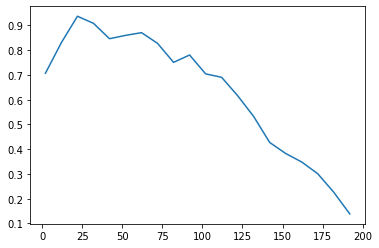

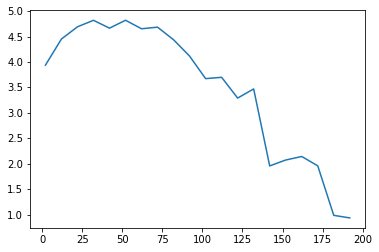

In [42]:
import seaborn as sns
sns.lineplot(n_clusters,DB)
plt.show()
sns.lineplot(n_clusters,Dunn)
plt.show()

## K-Means Clustering

In [45]:
X1, X2 = simulate_data_2(200)
df = pd.DataFrame({'X1': X1, 'X2': X2,}, columns=['X1', 'X2'])

In [46]:
df

,X1,X2
0,5.801081,12.178757
1,8.557269,11.869179
2,0.069280,24.563561
3,6.750666,18.270271
4,8.741371,9.163691
...,...,...
195,19.683571,24.850032
196,3.353494,1.695180
197,23.840215,18.377193
198,1.888631,9.867131


In [72]:
def calc_distance(X1, X2):
    return(sum((X1 - X2)**2))**0.5

In [130]:
for index, row in df.iterrows():
    if index == 0:
        print(row)
        print(calc_distance(row[:-1],centroids[0][:-1]))

X1           8.211351
X2          15.704202
X3          14.573800
X4           2.399829
X5          18.673271
Cluster    111.000000
Name: 0, dtype: float64
23.665186641419023


In [125]:
centroids[0][:-1]

X1    11.375419
X2     6.562705
X3    15.575338
X4    22.760159
X5    11.537678
Name: 163, dtype: float64

In [91]:
df.iloc[0]

X1           8.211351
X2          15.704202
X3          14.573800
X4           2.399829
X5          18.673271
Cluster    111.000000
Name: 0, dtype: float64

In [89]:
df.iloc[163]

X1          11.375419
X2           6.562705
X3          15.575338
X4          22.760159
X5          11.537678
Cluster    132.000000
Name: 163, dtype: float64

In [76]:
for center in centroids:
    print(center)

X1          11.375419
X2           6.562705
X3          15.575338
X4          22.760159
X5          11.537678
Cluster    132.000000
Name: 163, dtype: float64
X1          14.835474
X2          20.548148
X3           9.410841
X4           7.913314
X5           2.232419
Cluster    175.000000
Name: 28, dtype: float64
X1         22.895428
X2         15.767190
X3         22.585763
X4         13.514094
X5         20.571904
Cluster    65.000000
Name: 6, dtype: float64
X1         12.083401
X2         20.407978
X3          6.588538
X4          7.694057
X5         10.466419
Cluster    51.000000
Name: 189, dtype: float64
X1          2.827908
X2          9.055714
X3         15.927491
X4          5.943391
X5         12.204942
Cluster    24.000000
Name: 70, dtype: float64


In [133]:
# Randomly assign indeces of cluster centroids:
def initiate_centroids(n, df):
    centroids = []
    random.seed(42) # use this since we want to compare the different number of clusters
    
    #generate random centroid indeces
    initial_index_centroid = random.sample(range(0, len(df)), n)
    
    #find the data points corresponding the the indeces:
    for i in initial_index_centroid:
        centroids.append(df.loc[i])
    return centroids


# To calculate the distance between two points:
def calc_distance(X1, X2):
    return(sum((X1 - X2)**2))**0.5


# To find the closest centroid to each data point:
def findClosestCentroids(centroids, df):
    assigned_centroid = []
    
    #iterate over every data point in the dataframe:
    for index, row in df.iterrows():
        distance=[]
        
        #find distance of data point with each cluster:
        for center in centroids:
            distance.append(calc_distance(row[:-1], center[:-1]))
            
        #assign data point to closest cluster:
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid


#To update the centroid of the clusters:
def calc_centroids(clusters, df):
    
    #initiate empty list for new centroids of each cluster:
    new_centroids = []
    
    #df including each point and its respective cluster
    new_df = pd.concat([pd.DataFrame(df), pd.DataFrame(clusters, columns=['cluster'])],
                      axis=1)
    
    #iterate over the distinct clusters
    for c in set(new_df['cluster']):
        
        #take out the data points corresponding to each cluster:
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        
        #find the new cluster centroid which is the mean of the clusters we already assigned
        cluster_mean = current_cluster.mean(axis=0)
        
        #append the new centroid
        new_centroids.append(cluster_mean)
        
    return new_centroids


#Recursively find and update cluster centroids:
#n: number of clusters, df: dataframe of data points, iterations: number of iterations
def recursive_centroid_find(n, df, iterations):
    #initiate centroids:
    centroids = initiate_centroids(n, df)
    # Recursively call the functions again to update the mean of the clusters:
    for i in range(iterations):
        get_centroids = findClosestCentroids(centroids, df)
        centroids = calc_centroids(get_centroids, df)
        #print(pd.DataFrame(centroids))
        
        #plot the centroids after every iteration:
        #plt.figure()
        #plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], color='red')
        #plt.scatter(df.X1, df.X2, alpha=0.1)
        #plt.show()
    return pd.DataFrame(centroids)

In [134]:
pd.DataFrame(centroids)

,X1,X2,X3,X4,X5,Cluster
163,11.375419,6.562705,15.575338,22.760159,11.537678,132.0
28,14.835474,20.548148,9.410841,7.913314,2.232419,175.0
6,22.895428,15.767190,22.585763,13.514094,20.571904,65.0
189,12.083401,20.407978,6.588538,7.694057,10.466419,51.0
70,2.827908,9.055714,15.927491,5.943391,12.204942,24.0


In [135]:
n=5
centroids = initiate_centroids(n, df)
get_centroids = findClosestCentroids(centroids, df)
recursive_centroid_find(n, df, 1)

,X1,X2,X3,X4,X5,Cluster
0,14.331562,7.722663,12.996948,19.130468,11.355066,95.111111
1,15.823955,17.566949,10.995590,10.545203,3.673154,97.352941
2,18.348256,15.121431,19.584871,11.551653,18.258302,82.541667
3,12.414465,16.680320,5.072212,10.406120,15.221732,93.163265
4,6.587459,9.037919,15.215063,6.970476,12.232662,92.250000


In [49]:
df['Cluster'] = findClosestCentroids(centroids, df)

In [50]:
df

,X1,X2,Cluster
0,5.801081,12.178757,1
1,8.557269,11.869179,2
2,0.069280,24.563561,1
3,6.750666,18.270271,1
4,8.741371,9.163691,3
...,...,...,...
195,19.683571,24.850032,2
196,3.353494,1.695180,3
197,23.840215,18.377193,2
198,1.888631,9.867131,3


In [51]:
df.iloc[0][2]

1.0

In [52]:
def get_cluster_dict(df):
    cluster_dict = {}
    visited = []
    for n in range(0,len(df)):
        if int(df.iloc[n][2]) in visited:
            cluster_dict[int(df.iloc[n][2])] += [n]
        else:
            cluster_dict[int(df.iloc[n][2])] = [n]
            visited.append(int(df.iloc[n][2]))
    return cluster_dict

In [53]:
cluster_dict = get_cluster_dict(df)

In [54]:
len(cluster_dict)

5

# Running the pipeline:

### For the dataset with 2 columns ('Synthetic')

In [55]:
N = 200
X1, X2 = simulate_data_2(N)
df = pd.DataFrame({'X1': X1, 'X2': X2}, columns=['X1', 'X2'])

def main_KMeans(k, df):
    
    centroids = initiate_centroids(k, df)
    df['Cluster'] = findClosestCentroids(centroids, df)
    cluster_dict = get_cluster_dict(df)
    DB = Davies_Bouldin(cluster_dict,df)
    Dunn = dunn(ordered_result, cluster_dict)
    
    return DB, Dunn

In [56]:
DB, Dunn = main_KMeans(15,df)

In [57]:
DB

0.9955699383528245

In [58]:
Dunn

15.893418401087557

### For the dataset with 5 columns ('Thyroid')

In [61]:
N = 200
X1, X2, X3, X4, X5 = simulate_data_5(N)
df = pd.DataFrame({'X1': X1, 'X2': X2,'X3': X3, 'X4': X4, 'X5': X5}, columns=['X1', 'X2','X3', 'X4', 'X5'])

def main_KMeans(k, df):
    
    centroids = initiate_centroids(k, df)
    df['Cluster'] = findClosestCentroids(centroids, df)
    cluster_dict = get_cluster_dict(df)
    DB = Davies_Bouldin(cluster_dict,df)
    Dunn = dunn(ordered_result, cluster_dict)
    
    return DB, Dunn

In [63]:
n_clusters = []
DB = []
Dunn = []
for K in range(2, N-1, 10):
    n_clusters.append(K)
    DB.append(main(K, df)[0])
    Dunn.append(main(K,df)[1])

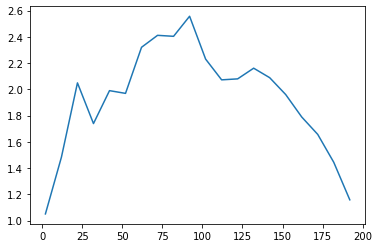

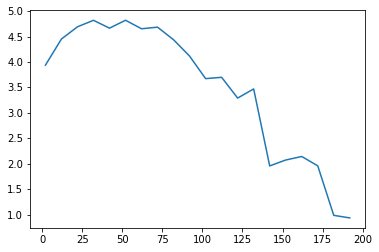

In [64]:
import seaborn as sns
sns.lineplot(n_clusters,DB)
plt.show()
sns.lineplot(n_clusters,Dunn)
plt.show()